In [274]:
# reading file using pandas library
import pandas as pd
import gzip
import json
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Appliances.json.gz')

In [276]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5.0,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5.0,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5.0,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5.0,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


In [287]:
# importing important library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [278]:
# main columns for recommedation system
column_names = ['asin', 'reviewerID', 'overall']

In [279]:
df=df[column_names]

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602777 entries, 0 to 602776
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   asin        602777 non-null  object 
 1   reviewerID  602777 non-null  object 
 2   overall     602777 non-null  float64
dtypes: float64(1), object(2)
memory usage: 18.4+ MB


1. very large number rows let's select first 10000

In [281]:
df=df.iloc[:10000]

In [282]:
df.reset_index(inplace=True)

In [284]:
df.head()

,index,asin,reviewerID,overall
0,0,1118461304,A3NHUQ33CFH3VM,5.0
1,1,1118461304,A3SK6VNBQDNBJE,5.0
2,2,1118461304,A3SOFHUR27FO3K,5.0
3,3,1118461304,A1HOG1PYCAE157,5.0
4,4,1118461304,A26JGAM6GZMM4V,5.0


# data exploration

In [288]:
def nan_visual(df,size):
    fig,ax=plt.subplots(figsize=size)
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
    plt.show()

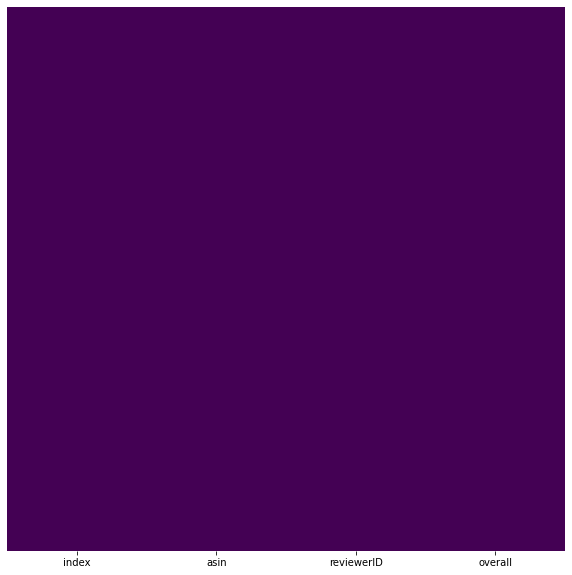

In [289]:
nan_visual(df,(10,10))

1. No nan values

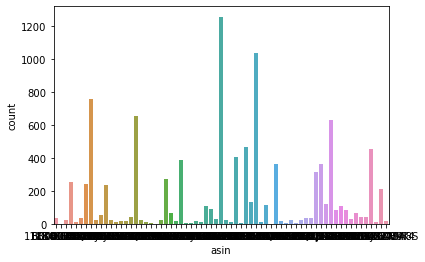

In [291]:
# distribution of count of productID rated by reviewer
sns.countplot(x='asin',data=df)

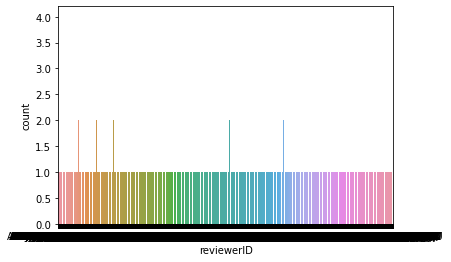

In [293]:
sns.countplot(x='reviewerID',data=df)

1. users have given review for 1-2 products only 
2. huge sparsity may be seen in recommedation system

# Data Preparation of the model

In [295]:
# train and test spilting
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.1)

In [296]:
n_products = df.asin.nunique()
n_users = df.reviewerID.nunique()
print('Num. of Products: '+ str(n_products))
print('Num of users: '+str(n_users))

Num. of Products: 67
Num of users: 9833


In [297]:
# sparsity
round(1.0-len(df)/float(n_users*n_products),4)

0.9848

1. very sparse matrix

In [298]:
# label encoding for each product and user
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
asin_integer_encoded = label_encoder.fit_transform(df['asin'])
reviewerID_integer_encoded=label_encoder.fit_transform(df['reviewerID'])

In [299]:
# matrix preparation
train_data_matrix = np.zeros((n_products, n_users)) # train_data_sparse matrix
r=np.zeros((n_products, n_users)) # rated matrix if r(i,j)=1 implies j rated product i else 0
test_data_matrix = np.zeros((n_products, n_users)) # train_data_sparse matrix
for i in range(len(train_data)):
    train_data_matrix[asin_integer_encoded[train_data['index'].iloc[i]], reviewerID_integer_encoded[train_data['index'].iloc[i]]] = df['overall'].iloc[train_data['index'].iloc[i]] 
    r[asin_integer_encoded[train_data['index'].iloc[i]], reviewerID_integer_encoded[train_data['index'].iloc[i]]]=1
for i in range(len(test_data)):
    test_data_matrix[asin_integer_encoded[test_data['index'].iloc[i]], reviewerID_integer_encoded[test_data['index'].iloc[i]]] = df['overall'].iloc[test_data['index'].iloc[i]]  

# model 1 , memory-based collaborative filtering(similarity)

In [309]:
# model corretness using rmse ( non-zero value of matrix)
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [304]:
from sklearn.metrics.pairwise import pairwise_distances
product_similarity = pairwise_distances(train_data_matrix, metric='cosine')
users_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [305]:
def predict(ratings, similarity, type='product'):
    if type == 'product':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'user':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [310]:
product_prediction = predict(train_data_matrix, product_similarity, type='product')
user_prediction = predict(train_data_matrix, users_similarity, type='user')

In [311]:
# test data correctness check
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Product-based CF RMSE: ' + str(rmse(product_prediction, test_data_matrix)))

User-based CF RMSE: 4.2451831341817705
Product-based CF RMSE: 4.295398608636583


In [312]:
# train data correctness check
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Product-based CF RMSE: ' + str(rmse(product_prediction, train_data_matrix)))

User-based CF RMSE: 4.4598939803394995
Product-based CF RMSE: 4.304281616742626


Comment:
    1. training and test MSE value is too large
    2. Alternate method is suitable as sparsity is large

# model 2 , linear regression based collaborative filtering

In [317]:
# assumtion
# x be some features of each product 
# theta be features of each user interested in features x 
# rating= theta' * x
# we will find theta and x using linear regression and gradient descent
# hyperparameters : Lambda (regulazation constant), alpha, number of iteration 

In [381]:
# finding error between predition and actual value in sparse matrix
def costfunction(X, y, r, theta, Lambda):
    predictions = np.dot(X, theta.T)
    err = predictions-y
    J = 1/2 * np.sum((err**2) * r)
    reg_x = Lambda/2 * np.sum(np.sum(theta**2))
    reg_theta = Lambda/2 * np.sum(np.sum(X**2))
    grad = J + reg_x + reg_theta
    return J, grad

In [382]:
# gradient descent optimization algorithms
def gradientDescent(X, y, r, theta, Lambda, num_iter, alpha):
    J_hist = []
    for i in range(num_iter):
        cost, grad = costfunction(X, y, r, theta, Lambda)
        X = X -  alpha*(np.dot(np.dot(X, theta.T) - y, theta) + Lambda*X)
        theta = theta - alpha*(np.dot((np.dot(X, theta.T) - y).T, X) + Lambda*theta) 
        J_hist.append(cost)
    return X, theta, J_hist

In [376]:
def normalizeRatings(y, r):
    ymean = np.sum(y, axis=1)/np.sum(r, axis=1)
    ynorm = np.sum(y, axis=1)*np.sum(r, axis=1) - ymean
    return ymean, ynorm

In [475]:
# initialisation of X and theta
X= 0.001*np.random.randn(n_products, 10) # assumption of 10 features
Theta = 0.001*np.random.randn(n_users, 10)
Lambda=25

In [476]:
ymean, ynorm = normalizeRatings(train_data_matrix, r)

In [477]:
x_up, theta_up, J_hist = gradientDescent(X, ((train_data_matrix-ymean.reshape(len(ymean),1))*r), r, Theta, Lambda, 3000,0.001)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

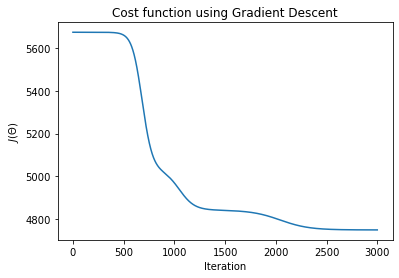

In [478]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(J_hist)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [479]:
predicted_matrix = np.dot(x_up, theta_up.T)

In [480]:
print('training MSE: ' + str(rmse(predicted_matrix+ymean.reshape(len(ymean),1), train_data_matrix)))

training MSE: 1.0294015938352918


In [481]:
print('test MSE:'+ str(rmse(predicted_matrix+ymean.reshape(len(ymean),1), test_data_matrix)))

test MSE:1.1596506729645673


Comment:
1. training MSE and test MSE are close to 1 
2. This model is preferred compared to model 1
3. It can be further optimized by tuning hyperparameter such as number of features ( assumed to be 10) , regularization constant, number of iteration for training purpose 

In [483]:
#Answer 
predicted_matrix+ymean.reshape(len(ymean),1)

array([[4.57575758, 4.57575758, 4.57575758, ..., 4.57575758, 4.57575758,
        4.57575758],
       [5.        , 5.        , 5.        , ..., 5.        , 5.        ,
        5.        ],
       [4.81818182, 4.81818182, 4.81818182, ..., 4.81818182, 4.81818182,
        4.81818182],
       ...,
       [4.8       , 4.8       , 4.8       , ..., 4.8       , 4.8       ,
        4.8       ],
       [3.96446701, 3.96446701, 3.96446701, ..., 3.96446701, 3.96446701,
        3.96446701],
       [4.36842105, 4.36842105, 4.36842105, ..., 4.36842105, 4.36842105,
        4.36842105]])